In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization, Conv2DTranspose, Conv2D
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and normalize data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = train_images.reshape(-1, 28, 28, 1)

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# Generator Model
generator = Sequential([
    Dense(7*7*256, input_shape=(100,)),
    LeakyReLU(0.2),
    Reshape((7, 7, 256)),
    BatchNormalization(),
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    LeakyReLU(0.2),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh')
])



In [4]:
# Discriminator Model
discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1)),
    LeakyReLU(0.2),
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    LeakyReLU(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])



In [9]:
# Compile Discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# GAN Model (stacking generator + discriminator)
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [11]:
# Training Loop
epochs = 10
batch_size = 128

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Get a random set of real images
    random_indices = np.random.randint(0, train_images.shape[0], batch_size)
    real_images_batch = train_images[random_indices]

    # Generate fake images from random noise
    noise_vectors = np.random.normal(0, 1, (batch_size, 100))
    fake_images_batch = generator.predict(noise_vectors)

    # Labels for real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train Discriminator on real and fake images
    discriminator.trainable = True
    loss_real = discriminator.train_on_batch(real_images_batch, real_labels)
    loss_fake = discriminator.train_on_batch(fake_images_batch, fake_labels)

    # Train Generator via GAN model
    noise_vectors = np.random.normal(0, 1, (batch_size, 100))
    misleading_labels = np.ones((batch_size, 1))
    discriminator.trainable = False
    generator_loss = gan.train_on_batch(noise_vectors, misleading_labels)
    gen_loss = generator_loss[0] if isinstance(generator_loss, (list, tuple)) else generator_loss
    print(f"  Discriminator Loss Real: {loss_real[0]:.4f}, Fake: {loss_fake[0]:.4f}, Generator Loss: {gen_loss:.4f}")


# Generate final images
noise_vectors = np.random.normal(0, 1, (10, 100))
generated_images = generator.predict(noise_vectors)



Epoch 1/10
4/4 [==============================] - 0s 11ms/step
  Discriminator Loss Real: 0.7142, Fake: 0.7050, Generator Loss: 0.5353
Epoch 2/10
4/4 [==============================] - 0s 9ms/step
  Discriminator Loss Real: 0.2902, Fake: 0.7159, Generator Loss: 0.3366
Epoch 3/10
4/4 [==============================] - 0s 9ms/step
  Discriminator Loss Real: 0.1125, Fake: 0.7282, Generator Loss: 0.1802
Epoch 4/10
4/4 [==============================] - 0s 9ms/step
  Discriminator Loss Real: 0.0276, Fake: 0.7357, Generator Loss: 0.0775
Epoch 5/10
4/4 [==============================] - 0s 10ms/step
  Discriminator Loss Real: 0.0086, Fake: 0.7342, Generator Loss: 0.0368
Epoch 6/10
4/4 [==============================] - 0s 10ms/step
  Discriminator Loss Real: 0.0030, Fake: 0.7351, Generator Loss: 0.0157
Epoch 7/10
4/4 [==============================] - 0s 10ms/step
  Discriminator Loss Real: 0.0020, Fake: 0.7319, Generator Loss: 0.0076
Epoch 8/10
4/4 [==============================] - 0s 10ms/

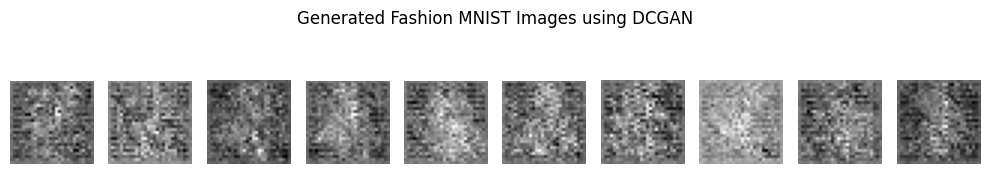

In [13]:
# Plot generated images
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Fashion MNIST Images using DCGAN")
plt.tight_layout()
plt.show()
